# This notebook contains:
* Arrays of rain rate intensity, frequency and HIM8 BT from ungridded files (redo)
* Code to calculate the mean channel 13 brightness temp using bathymetry to mask land vs ocean, for radar domains
* Diurnal cycle plots for there three outputs

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
import dask.array as da
from scipy.stats import circmean
import datetime
import pytz
from datetime import datetime, timedelta

# Calculate Himawari diurnal cycles:
* Read in files

In [3]:
# read in bathymetry files
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

# read in satellite files
def him8_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith("_ch13BT_regridded_2kmres.nc"):  
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/home/563/ac9768/himawari_regridded_files"
files = him8_files(directory)

# Climatology

In [ ]:
# first for climatology, barra not included
# function to calculate mean brightness temperature for the entire rodar domain + for bathymetry>0 and <0 requirements
def read_netcdf_him8(file_path):
    with xr.open_mfdataset(file_path,engine="h5netcdf", chunks="auto") as ds:
        # radar site boundaries
        data_towns = ds.ch13BT.sel(lat=slice(-20.768799,-18.065369),lon=slice(145.10834,147.99347))
        data_cairns = ds.ch13BT.sel(lat=slice(-18.165955,-15.463379),lon=slice(144.26343,147.1026))
        data_willis = ds.ch13BT.sel(lat=slice(-17.636353,-14.93396),lon=slice(148.54926,151.37994))
        # select land vs ocean for cairns and townsville
        bathymetry_towns = ds_bath["z"].sel(x=data_towns.lon,y=data_towns.lat,method="nearest")
        bathymetry_cairns = ds_bath["z"].sel(x=data_cairns.lon,y=data_cairns.lat,method="nearest")
        
        bathymetry_towns_land = bathymetry_towns> 0 
        bathymetry_cairns_land = bathymetry_cairns> 0 
        
        bathymetry_towns_ocean = bathymetry_towns<= 0 
        bathymetry_cairns_ocean = bathymetry_cairns<= 0 
        
        land_towns = xr.where(bathymetry_towns_ocean, np.nan, data_towns)
        land_cairns = xr.where(bathymetry_cairns_ocean, np.nan, data_cairns)
        ocean_towns = xr.where(bathymetry_towns_land, np.nan, data_towns)
        ocean_cairns = xr.where(bathymetry_cairns_land, np.nan, data_cairns)
        
        # calculate mean
        mean_towns_land = land_towns.groupby(land_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_cairns_land = land_cairns.groupby(land_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_towns_ocean = ocean_towns.groupby(ocean_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_cairns_ocean = ocean_cairns.groupby(ocean_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_willis = data_willis.groupby(data_willis.time.dt.hour).mean(dim=["lat","lon","time"])  
    return mean_towns_land, mean_cairns_land,mean_towns_ocean,mean_cairns_ocean,mean_willis

In [154]:
mean_towns_land,mean_cairns_land,mean_towns_ocean,mean_cairns_ocean,mean_willis = read_netcdf_him8(files)

In [ ]:
%%time
# h8_towns_land = mean_towns_land.compute()
# h8_cairns_land = mean_cairns_land.compute()
h8_towns_ocean = mean_towns_ocean.compute()
h8_cairns_ocean = mean_cairns_ocean.compute()
# h8_willis = mean_willis.compute()

In [156]:
# change to aest
# h8towns_land = np.roll(h8_towns_land,shift=10)
# h8cairns_land = np.roll(h8_cairns_land,shift=10)
h8towns_ocean = np.roll(h8_towns_ocean,shift=10)
h8cairns_ocean = np.roll(h8_cairns_ocean,shift=10)
# h8willis_ocean = np.roll(h8_willis,shift=10)

NameError: name 'h8_towns_ocean' is not defined

In [89]:
# save arrays
# np.save('/home/563/ac9768/himawari_regridded_files/h8_clim_willis_ocean.npy', h8willis_ocean)

# Regimes

In [4]:
# read in barra files for wind regimes
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")
def read_netcdf_him8(file_path,barra_site,wdir1,wdir2,ne=None,towns=None,cairns=None):
    with xr.open_mfdataset(file_path,engine="h5netcdf", chunks="auto") as ds:
        # barra conditions
        ds_barra = barra_site.sortby('time') 
        ds_selected = ds_barra.sel(time=slice('2016-01-01', '2020-04-01'))
        barra = ds_selected.sel(time=~(ds_selected['time.month'] == 4))
        winds = barra.wind_dir.compute()
        if ne==True:
            wind_dir = winds[(winds>=wdir1)&(winds<=wdir2)]
        else:
            wind_dir = winds[(winds>wdir1)&(winds<=wdir2)]
        wind_times = wind_dir.time.values

        if towns==True:
            data_towns = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-20.768799,-18.065369),lon=slice(145.10834,147.99347))
            bathymetry_towns = ds_bath["z"].sel(x=data_towns.lon,y=data_towns.lat,method="nearest")
            bathymetry_towns_land = bathymetry_towns> 0 
            bathymetry_towns_ocean = bathymetry_towns<= 0 
            land_towns = xr.where(bathymetry_towns_ocean, np.nan, data_towns)
            ocean_towns = xr.where(bathymetry_towns_land, np.nan, data_towns)
            mean_land = land_towns.groupby(land_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
            mean_ocean = ocean_towns.groupby(ocean_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
        elif cairns==True:
            data_cairns = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-18.165955,-15.463379),lon=slice(144.26343,147.1026))
            bathymetry_cairns = ds_bath["z"].sel(x=data_cairns.lon,y=data_cairns.lat,method="nearest")
            bathymetry_cairns_land = bathymetry_cairns> 0 
            bathymetry_cairns_ocean = bathymetry_cairns<= 0 
            land_cairns = xr.where(bathymetry_cairns_ocean, np.nan, data_cairns)
            ocean_cairns = xr.where(bathymetry_cairns_land, np.nan, data_cairns)
            mean_land = land_cairns.groupby(land_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
            mean_ocean = ocean_cairns.groupby(ocean_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
        else:
            data_willis = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-17.636353,-14.93396),lon=slice(148.54926,151.37994))
            mean_land = 1
            mean_ocean = data_willis.groupby(data_willis.time.dt.hour).mean(dim=["lat","lon","time"])  
    return mean_land,mean_ocean

In [5]:
mean_land,mean_ocean = read_netcdf_him8(files,barra_towns,0,90,ne=True,towns=True,cairns=False)

In [6]:
mean_landC,mean_oceanC = read_netcdf_him8(files,barra_cairns,0,90,ne=True,towns=False,cairns=True)

In [21]:
na,mean_W = read_netcdf_him8(files,barra_willis,0,90,ne=True,towns=False,cairns=False)

In [7]:
h8_oceanT = mean_ocean.compute()
h8_oceanC = mean_oceanC.compute()

In [8]:
# change to aest
h8T = np.roll(h8_oceanT,shift=10)
h8C = np.roll(h8_oceanC,shift=10)

In [9]:
# save arrays
np.save('/home/563/ac9768/himawari_regridded_files/h8_ne_cairns_ocean-v2.npy', h8C)
np.save('/home/563/ac9768/himawari_regridded_files/h8_ne_towns_ocean-v2.npy', h8T)

# Calculate radar diurnal cycles

In [25]:
def path_to_radar_ds(radar_site_no):
    """
    List of yyyymm (year+month) with available radar data.
    For each yyyymm create a list of entire file paths to netCDF4 files.

    Parameters:
    - radar_site_no (str): Radar site number- BoM ID's for radar locations: Townsville=73, Cairns=19, and Willis Island=41 

    Returns:
    - list: list object of netCDF4 files
    """
    list = ["202201","202202","202203","202204","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] 
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list

towns_radar_files = path_to_radar_ds("73")
cairns_radar_files = path_to_radar_ds("19")
willis_radar_files = path_to_radar_ds("41")

In [37]:
def UTC_to_LST(ds,longitude,timezone,output_string_format):
    # Convert time to pandas datetime objects
    time_values = pd.to_datetime(ds['time'].values,unit='ns')
    
    # Convert nanoseconds to datetime objects in UTC
    time_objects_utc = pd.to_datetime(time_values, unit='ns')
    
    # Define the time zone for the location
    local_timezone = pytz.timezone(timezone)
    
    # Convert UTC datetime objects to the local time zone
    time_objects_local = time_objects_utc.tz_localize('UTC').tz_convert(local_timezone)
    
    # Calculate the offset from UTC based on the longitude
    # 4 minutes per degree of longitude from the prime meridian
    # longitude_offset = timedelta(minutes=(longitude / 360) * 60)

    #  # Calculate the offset from UTC based on the longitude
    # # 4 minutes per degree of longitude from the prime meridian
    # longitude_offset = np.timedelta64(int((longitude / 360) * 60), 'm')
    longitude_offset = np.timedelta64(int((longitude / 360) * 1440), 'm')
    # # Adjust the time to local solar time based on the longitude offset
    # time_objects_solar = time_objects_local - longitude_offset

    
    # Adjust the time to local solar time based on the longitude offset
    time_objects_solar = time_objects_local + longitude_offset
    
    # Format datetime objects as strings or as datetime 64
    time_strings_solar = pd.to_datetime(time_objects_solar.values,unit='ns')
    ds["time"] = time_strings_solar
    return ds

In [49]:
%%time
# Convert ds to LST
def open_radar(file_path):
    # Open the dataset and select the desired time slice
    with xr.open_mfdataset(file_path, engine="h5netcdf",
          chunks="auto").sel(time=slice('2022-01-01T00:00:00.000000000',
                                        '2022-01-01T02:00:00.000000000')) as ds:
        # Call the function to adjust time from UTC to LST
        # ds = UTC_to_LST(ds, 145.683, 'Australia/Sydney', None)  # If format is None, keep as datetime objects
        # ds['time'] = pd.to_datetime(ds['time'].values)
        return ds
test = open_radar(cairns_radar_files)

CPU times: user 1min 22s, sys: 1.82 s, total: 1min 24s
Wall time: 1min 39s


In [41]:
test

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 25, y: 301, x: 301)
Coordinates:
  * x          (x) int32 1kB -150000 -149000 -148000 ... 148000 149000 150000
  * y          (y) int32 1kB -150000 -149000 -148000 ... 148000 149000 150000
  * time       (time) datetime64[ns] 200B 2022-01-01T09:42:00 ... 2022-01-01T...
Data variables:
    rainrate   (time, y, x) float32 9MB dask.array<chunksize=(25, 301, 301), meta=np.ndarray>
    longitude  (time, y, x) float32 9MB dask.array<chunksize=(25, 301, 301), meta=np.ndarray>
    latitude   (time, y, x) float32 9MB dask.array<chunksize=(25, 301, 301), meta=np.ndarray>
    isfile     (time) int32 100B dask.array<chunksize=(25,), meta=np.ndarray>
Attributes: (12/56)
    summary:                       Level 2 dataset from the Australian radar ...
    history:                       created by Joshua Soderholm on gadi.nci.or...
    acknowledgement:               This work is support by the Bureau of Mete...
    institution:                   Bureau of Meteorology
    keywords:                      radar, Doppler, dual-polarization
    licence:                       CC4.0-BY-NC (if the latest dataset licence...
    ...                            ...
    geospatial_vertical_min:       0
    geospatial_vertical_max:       2500
    comments:                      Radar reflectivity has not been corrected ...
    geospatial_projection:         Azimuthal equidistant projection
    geospatial_vertical_positive:  up
    geospatial_vertical_units:     m

In [4]:
def process_hour_freq(ds):
    """
    Sum the number of non raining points (value = 0) across x, y and time ignoring Nans. Sum the
    number of raining points. Compute those values. Calculate the total of valid data points (raining + non-raining). Calculate the frequency
    where the number of raining points is divided by the total valid points * 100.
    
    Parameters:
    - ds (str): Path to the netCDF file(s).
    
    Returns:
    - int: Frequency of raining points (%)
    """
    number_of_nonraining_points = (ds == 0).where(~ds.isnull()).sum(dim=['x', 'y', 'time'])
    number_of_raining_points = (ds != 0).where(~ds.isnull()).sum(dim=['x', 'y', 'time'])
    total_count = (number_of_nonraining_points) + (number_of_raining_points)
    freq = (number_of_raining_points / total_count) * 100
    return freq

In [5]:
def process_hour_int(ds):
    """
    Sum the number of non raining points (value = 0) across x, y and time ignoring Nans. Sum the
    number of raining points. Compute those values. Calculate the total of valid data points (raining + non-raining). Calculate the frequency
    where the number of raining points is divided by the total valid points * 100.
    
    Parameters:
    - ds (str): Path to the netCDF file(s).
    
    Returns:
    - int: Intensity of raining points (mm/h)
    """
    
    intensity = ds.mean(dim=["time",'x','y'],skipna=True) 
    return intensity

In [128]:
def create_radar_mask(file_path, threshold,chunks={'time': 'auto', 'x': 'auto', 'y': 'auto'},land=None,ocean=None):
    ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
    ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))
    print("bathymetry")
    with xr.open_mfdataset(file_path, engine="netcdf4",combine='by_coords', chunks=chunks, parallel=True) as ds:
        ds_mean = ds.rainrate.mean(dim='time')
        condition1 = ~ds.rainrate.mean(dim='time').isnull()
        print(condition1.compute().sum())
        print("calculated mean rr")
        file = xr.open_dataset(file_path[0], engine="netcdf4") 
        bathymetry = ds_bath["z"].sel(x=file.longitude,y=file.latitude,method="nearest")
        masked_beam_blockage = xr.where((ds_mean < threshold), np.zeros_like(ds_mean),np.ones_like(ds_mean)) ##each hour then has its own mask
        if land==True:
            bath = xr.where((bathymetry <= 0), np.zeros_like(bathymetry),np.ones_like(bathymetry))
            condition2 = bath.astype(bool)
            condition3 = masked_beam_blockage.astype(bool)
            mask = condition1 & condition2 & condition3
        elif ocean==True:
            bath = xr.where((bathymetry > 0), np.zeros_like(bathymetry),np.ones_like(bathymetry))
            condition2 = bath.astype(bool)
            condition3 = masked_beam_blockage.astype(bool)
            mask = condition1 & condition2 & condition3
        else:
            mask = ~ds.rainrate.mean(dim='time').isnull()
    return mask 

In [129]:
%%time
cairns_land = create_radar_mask(cairns_radar_files, 1.2,land=True,ocean=False)

bathymetry
<xarray.DataArray 'rainrate' ()> Size: 8B
array(68365)
calculated mean rr
CPU times: user 34min 5s, sys: 4min 15s, total: 38min 21s
Wall time: 27min 31s


In [7]:
%%time
cairns_ocean = create_radar_mask(cairns_radar_files, 1.2,land=False,ocean=True)

bathymetry
calculated mean rr
CPU times: user 20min 13s, sys: 3min 1s, total: 23min 15s
Wall time: 18min 25s


In [131]:
willis_mask = create_radar_mask(willis_radar_files, 1.2,land=False,ocean=False)

bathymetry
<xarray.DataArray 'rainrate' ()> Size: 8B
array(65836)
calculated mean rr


In [25]:
%%time
towns_land = create_radar_mask(towns_radar_files, 0.8,land=True,ocean=False)

bathymetry
calculated mean rr
CPU times: user 15min 52s, sys: 2min 19s, total: 18min 12s
Wall time: 14min 51s


In [130]:
%%time
towns_ocean = create_radar_mask(towns_radar_files, 0.8,land=False,ocean=True)

bathymetry
<xarray.DataArray 'rainrate' ()> Size: 8B
array(70616)
calculated mean rr


KeyboardInterrupt: 

In [135]:
def open_radar(file_path):
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:            
        nan_to_zero = ds.rainrate.fillna(0) # creates a much lower mean threshold (if used for masking) - includes non raining periods           
        return ds,nan_to_zero
entire_radar_dsC,nan_filled_dsC = open_radar(cairns_radar_files)
# entire_radar_ds,nan_filled_ds = open_radar(towns_radar_files)
# entire_radar_ds,nan_filled_ds = open_radar(towns_radar_files)
entire_radar_dsW,nan_filled_dsW = open_radar(willis_radar_files)
# apply the masks created above
masked_ds_land = nan_filled_dsC.where(cairns_land)
# masked_ds_ocean = nan_filled_ds.where(cairns_ocean)
# masked_ds_landT = nan_filled_ds.where(towns_land)
# masked_ds_oceanT = nan_filled_ds.where(towns_ocean)
mask_willis = nan_filled_dsW.where(willis_mask)

In [136]:
def radar_variable_isfile_mask(entire_radar_dataset,masked_radar_ds):
    qc = entire_radar_dataset.isfile.compute()[entire_radar_dataset.isfile.compute()>0] # when greater than 0: valid time-step
    final_mask = masked_radar_ds.where(qc)
    return final_mask
masked_land_dsC = radar_variable_isfile_mask(entire_radar_dsC,masked_ds_land)
# masked_ocean_dsC = radar_variable_isfile_mask(entire_radar_dsC,masked_ds_ocean)
# masked_land_dsT = radar_variable_isfile_mask(entire_radar_ds,masked_ds_landT)
# masked_ocean_dsT = radar_variable_isfile_mask(entire_radar_ds,masked_ds_oceanT)
masked_willis = radar_variable_isfile_mask(entire_radar_dsW,mask_willis)

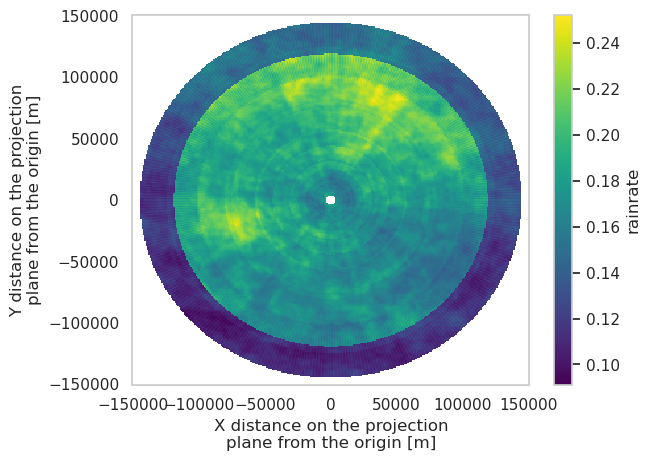

In [45]:
mask_willis.mean('time').plot()

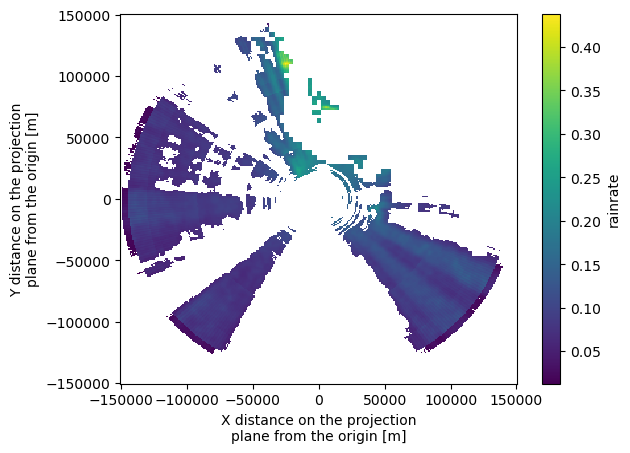

In [13]:
masked_ds_land.mean(['time']).plot()

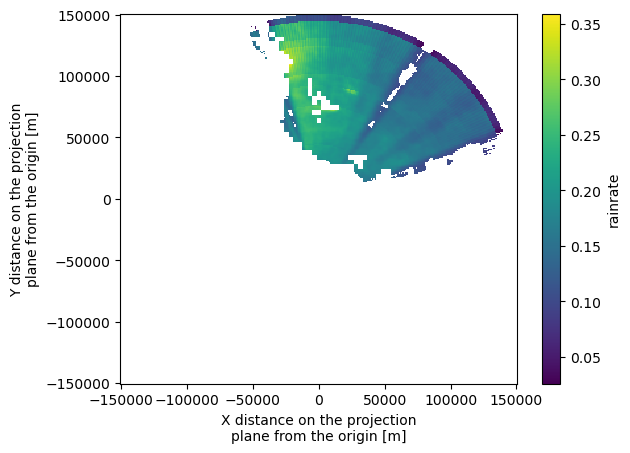

In [10]:
masked_ds_ocean.mean(['time']).plot()

In [10]:
def generate_diurnal_ds(ds,wind_dir,wind_dir1,wind_dir2,ne=None):
    # select wind directions
    winds = wind_dir.wind_dir.compute()
    if ne==True:
        wind = winds[(winds>=wind_dir1)&(winds<=wind_dir2)]
    else:
        wind = winds[(winds>wind_dir1)&(winds<=wind_dir2)]
    # select wind time values
    wind = wind.drop_duplicates(dim="time")
    wind_times = wind.time.values
    wind_times.sort() 
    print(len(wind_times))
    # Define the time window of 30 minutes - to select radar data +30/-30min of selected BARRA2 wind direction hour
    window_size = pd.Timedelta(minutes=30)
    # Initialize empty list to store selected data
    selected_data = []
    # Loop through each time point in wind (directions chosen above); or for deep easterlies, through: wind_speed_SE_10ms
    for time in wind_times:
        # Calculate the start and end times of the window
        window_start = time - window_size
        window_end = time + window_size
        # Select the data within the time window from ds2 using slice
        data_within_window = ds.sel(time=slice(window_start, window_end))
        # Append the selected data to the list
        selected_data.append(data_within_window)
    # Concatenate the selected data into a single xarray dataset
    radar_composite_winds = xr.concat(selected_data, dim='time').drop_duplicates(dim="time")
    # convert dataset from UTC to LST
    # selected_radar_ds_to_LST = UTC_to_LST(radar_composite_winds,long_LST,'Australia/Sydney',"%Y-%m-%dT%H:%M")
    # selected_radar_ds_to_LST_array = xr.DataArray(selected_radar_ds_to_LST.values,dims=('time','y','x'), 
    #                               coords={'time': selected_radar_ds_to_LST.time,
    #                                      'y':selected_radar_ds_to_LST.y,
    #                                      'x':selected_radar_ds_to_LST.x}).drop_duplicates(dim="time")
    print(len(radar_composite_winds.time))
    intensity = radar_composite_winds.groupby(radar_composite_winds.time.dt.hour).apply(process_hour_int)
    return intensity

In [11]:
def save_as_zarray(file_path,ds):
    save_file_path = file_path
    ds.to_zarr(save_file_path)
    return

In [12]:
# open barra 850 hPa wind datasets
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

In [139]:
ne = generate_diurnal_ds(masked_land_dsC,barra_cairns,0,90,ne=True) 
save_as_zarray("/scratch/v46/ac9768/cairns_ne_land_rri-v2.zarr",ne)

3828
33437


In [140]:
se = generate_diurnal_ds(masked_land_dsC,barra_cairns,90,180,ne=False)
save_as_zarray("/scratch/v46/ac9768/cairns_se_land_rri-v2.zarr",se)

20198
170332


In [36]:
sw = generate_diurnal_ds(masked_ocean_dsT,barra_towns,180,270,ne=False)
save_as_zarray("/scratch/v46/ac9768/towns_sw_ocean_rri.zarr",sw)

2535
17597


In [37]:
nw = generate_diurnal_ds(masked_ocean_dsT,barra_towns,270,360,ne=False)
save_as_zarray("/scratch/v46/ac9768/towns_nw_ocean_rri.zarr",nw)

1799
11960


In [38]:
%%time
clim = generate_diurnal_ds(masked_ocean_dsT,barra_towns,0,360,ne=True)
save_as_zarray("/scratch/v46/ac9768/towns_clim_ocean_rri.zarr",clim)

30288
203004
CPU times: user 20min 55s, sys: 1min 46s, total: 22min 42s
Wall time: 15min 7s


In [137]:
masked_land_dsC.mean(dim='time').compute().isnull().sum()

<xarray.DataArray 'rainrate' ()> Size: 8B
array(66333)

In [138]:
masked_willis.mean(dim='time').compute().isnull().sum()

<xarray.DataArray 'rainrate' ()> Size: 8B
array(24765)

# Radar rain rate frequency calcs

In [15]:
def calc_rr(file_path,barra_site,wdir1,wdir2,mask,chunks={'time': 'auto', 'x': 'auto', 'y': 'auto'},regime=None,ne=None):
    """
    If winds are from the NE make condition where NE wind regimes is true 0degrees is =>.
    Fill Nan with zeros (so that non raining points are filled as zero). Apply the (land/ocean/willis CAPPI grid) masks to only look at valid time
    steps, mask using the isfile variable. 
    Group ds by hour, and apply the process_hour_freq function. Return frequencies (%) or intensity.
    
    Parameters:
    - file_path (str): Path to the netCDF file(s).
    - barra_site (ds): BARRA-2 850hPa wind regime dataset (Townsville, Cairns or Willis Island)
    - wdir1 (int): Wind direction (degrees) beginning of range
    - wdir2 (int): Wind direction (degrees) end of range
    
    Returns:
    - array: data array of frequencies for each hour of the day.
    """
    with xr.open_mfdataset(file_path, engine="netcdf4",combine='by_coords', chunks=chunks, parallel=True) as ds:
        ds_mean = ds.rainrate.mean(dim='time')
        print('calculated ds_mean')
        # open bathymetry dataset to apply land-sea masks
        ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
        ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

        # Make a condition where if regimes are true, select specific times from dataset
        if regime==True:
            ds_barra = barra_site.sortby("time")
            winds = ds_barra.wind_dir.compute()
            if ne==True:
                wind_dir = winds[(winds>=wdir1)&(winds<=wdir2)]
            else:
                wind_dir = winds[(winds>wdir1)&(winds<=wdir2)]
            wind_regime = wind_dir.time.values
            # make a window to use rr data 30min before and after the hour
            window_size = pd.Timedelta(minutes=30)
            selected_data = []
                # # Loop through each time point in wind regime
            for time in wind_regime: 
                # Calculate the start and end times of the window
                window_start = time - window_size
                window_end = time + window_size
                # Select the data within the time window from ds2 using slice
                # data_within_window = ds.rainrate.sel(time=slice(window_start, window_end))
                data_within_window = ds.sel(time=slice(window_start, window_end))
                # Append the selected data to the list
                selected_data.append(data_within_window)
            select_regime = xr.concat(selected_data, dim='time')
            apply_mask = select_regime.rainrate.where(mask)
            nan_to_zero = apply_mask.rainrate.fillna(0)
            # create a mask which looks if the isfile variable>0 at selected times
            maskisfile = select_regime.isfile[select_regime.isfile.values>0]
            # mask invalid time and spatial points (non-raining points kept as zeros)
            valid_data_points = nan_to_zero.where(maskisfile)
        else:
            selected_data = []
            window_size = pd.Timedelta(minutes=30)
            # Loop through each time point in wind regime
            for time in ds.time.values: 
                # Calculate the start and end times of the window
                window_start = time - window_size
                window_end = time + window_size
                # Select the data within the time window from ds2 using slice
                # data_within_window = ds.rainrate.sel(time=slice(window_start, window_end))
                data_within_window = ds.sel(time=slice(window_start, window_end))
                # Append the selected data to the list
                selected_data.append(data_within_window)
            select_regime = xr.concat(selected_data, dim='time')
            ### apply mask
            apply_mask = select_regime.rainrate.where(mask) #boolean mask, xr.where(cairns_land>=0,rr.rainrate,np.nan) = non-boolean mask
            nan_to_zero = apply_mask.rainrate.fillna(0)
            maskisfile = ds.isfile[ds.isfile.values>0]
            valid_data_points = nan_to_zero.where(maskisfile)
            # apply process_hour_freq function to groupby hour object 
        print('apply functions')
        # intensity = valid_data.groupby(valid_data.time.dt.hour).apply(process_hour_int)
        frequencies = valid_data.groupby(valid_data.time.dt.hour).apply(process_hour_freq)
    return frequencies#,intensity

In [ ]:
%%time
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

# towns_rri = calc_rr(towns_radar_files,barra_towns,270,360,towns_land,chunks={'time': 'auto', 'x': 'auto', 'y': 'auto'},regime=False,ne=False)
cairns_rrf = calc_rr(cairns_radar_files,barra_cairns,270,360,cairns_land_test,chunks={'time': 'auto', 'x': 'auto', 'y': 'auto'},regime=False,ne=False)

calculated ds_mean


# Plotting function

In [11]:
def diurnal_cycle_plot(title,bt_min,bt_max,f_max,rr_max,
                       h8_towns_land,h8_cairns_land,h8_towns_ocean,h8_cairns_ocean,h8_willis_ocean,
                      raf_towns_land,raf_cairns_land,raf_towns_ocean,raf_cairns_ocean,raf_willis_ocean,
                      rai_towns_land,rai_cairns_land,rai_towns_ocean,rai_cairns_ocean,rai_willis_ocean):
    # layout of plots
    fig,ax = plt.subplots(3,2, figsize=[10,10])
    fig.patch.set_facecolor('white')
    fig.suptitle(title,y=1.02,fontsize=25)
    fig.tight_layout()
    sns.set_theme(style="whitegrid")
    # create titles for columns
    ax[0,0].set_title('Land',fontsize=20,pad=15)
    ax[0,1].set_title('Ocean',fontsize=20,pad=15)
    # create yaxis labels
    ax[0,0].set_ylabel('Ch.13 BT (K)',fontsize=15)
    ax[0,0].set_ylim(bt_min,bt_max)
    ax[0,0].invert_yaxis()
    ax[0,1].set_ylim(bt_min,bt_max)
    ax[0,1].invert_yaxis()
    ax[1,0].set_ylabel('RR Frequency (%)',fontsize=15)
    ax[1,0].set_ylim(0,f_max)
    ax[1,1].set_ylim(0,f_max)
    ax[2,0].set_ylabel('RR Intensity (mm/h)',fontsize=15)
    ax[2,0].set_ylim(0,rr_max)
    ax[2,1].set_ylim(0,rr_max)
    # create xaxis labels
    ax[2,0].set_xlabel('Hour (LST)',fontsize=15)
    ax[2,1].set_xlabel('Hour (LST)',fontsize=15)
    ax[0,0].set_xlim(0,23) 
    ax[0,1].set_xlim(0,23) 
    ax[1,0].set_xlim(0,23) 
    ax[1,1].set_xlim(0,23) 
    ax[2,0].set_xlim(0,23) 
    ax[2,1].set_xlim(0,23) 
    xticks = ["0","3","6","9","12","15","18","21"]
    ax[0,0].set_xticks(np.arange(0,24,3),xticks)
    ax[0,1].set_xticks(np.arange(0,24,3),xticks)
    ax[1,0].set_xticks(np.arange(0,24,3),xticks)
    ax[1,1].set_xticks(np.arange(0,24,3),xticks)
    ax[2,0].set_xticks(np.arange(0,24,3),xticks)
    ax[2,1].set_xticks(np.arange(0,24,3),xticks)
    # add gridlines
    ax[0,0].grid(alpha=0.5) 
    ax[0,1].grid(alpha=0.5,color="white") 
    ax[0,1].set_facecolor('lightgray')
    ax[1,0].grid(alpha=0.5) 
    ax[1,1].grid(alpha=0.5,color="white") 
    ax[1,1].set_facecolor('lightgray')
    ax[2,0].grid(alpha=0.5) 
    ax[2,1].grid(alpha=0.5,color="white")
    ax[2,1].set_facecolor('lightgray')

    # plot data
    # himawari
    ax[0,0].plot(np.arange(0,24,1),h8_towns_land,linewidth=3,color='teal',label="Townsville")
    ax[0,0].plot(np.arange(0,24,1),h8_cairns_land,linewidth=3,color='magenta',label="Cairns")
    ax[0,1].plot(np.arange(0,24,1),h8_towns_ocean,linewidth=3,color='teal',label="Townsville")
    ax[0,1].plot(np.arange(0,24,1),h8_cairns_ocean,linewidth=3,color='magenta',label="Cairns")
    ax[0,1].plot(np.arange(0,24,1),h8_willis_ocean,linewidth=3,color='navy',label="Willis Island")
    ax[0,1].legend(bbox_to_anchor=(1.02, 1.4),)
    # rain rate frequency
    ax[1,0].plot(np.arange(0,24,1),raf_towns_land,linewidth=3,color='teal')
    ax[1,0].plot(np.arange(0,24,1),raf_cairns_land,linewidth=3,color='magenta')
    ax[1,1].plot(np.arange(0,24,1),raf_towns_ocean,linewidth=3,color='teal')
    ax[1,1].plot(np.arange(0,24,1),raf_cairns_ocean,linewidth=3,color='magenta')
    ax[1,1].plot(np.arange(0,24,1),raf_willis_ocean,linewidth=3,color='navy')
    # rain rate intensity (including raining times)
    ax[2,0].plot(np.arange(0,24,1),rai_towns_land,linewidth=3,color='teal')
    ax[2,0].plot(np.arange(0,24,1),rai_cairns_land,linewidth=3,color='magenta')
    ax[2,1].plot(np.arange(0,24,1),rai_towns_ocean,linewidth=3,color='teal')
    ax[2,1].plot(np.arange(0,24,1),rai_cairns_ocean,linewidth=3,color='magenta')
    ax[2,1].plot(np.arange(0,24,1),rai_willis_ocean,linewidth=3,color='navy')
    return

In [12]:
# read in H8 arrays to plot (these arrays have been produced for aest time)
# clim
h8towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_towns_land.npy')
h8cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_cairns_land.npy')
h8towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_towns_ocean.npy')
h8cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_cairns_ocean.npy')
h8willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_willis_ocean.npy')
# ne
h8_ne_towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_towns_land.npy')
h8_ne_towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_towns_ocean-v2.npy')
h8_ne_cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_cairns_land.npy')
h8_ne_cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_cairns_ocean-v2.npy')
h8_ne_willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_willis_ocean.npy')
# se
h8_se_towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_towns_land.npy')
h8_se_towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_towns_ocean.npy')
h8_se_cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_cairns_land.npy')
h8_se_cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_cairns_ocean.npy')
h8_se_willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_willis_ocean.npy')
# sw
h8_sw_towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_towns_land.npy')
h8_sw_towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_towns_ocean.npy')
h8_sw_cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_cairns_land.npy')
h8_sw_cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_cairns_ocean.npy')
h8_sw_willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_willis_ocean.npy')
# nw
h8_nw_towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_towns_land.npy')
h8_nw_towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_towns_ocean.npy')
h8_nw_cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_cairns_land.npy')
h8_nw_cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_cairns_ocean.npy')
h8_nw_willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_willis_ocean.npy')

In [13]:
# read in Radar rainrate frequency arrays to plot (these arrays have been produced for aest time)
# clim
towns_rrf_land_clim = np.load('/home/563/ac9768/radar/towns_rrf_land_aest.npy')
towns_rrf_ocean_clim = np.load('/home/563/ac9768/radar/towns_rrf_ocean_aest.npy')
cairns_rrf_land_clim = np.load('/home/563/ac9768/radar/cairns_rrf_land_aest.npy')
cairns_rrf_ocean_clim = np.load('/home/563/ac9768/radar/cairns_rrf_ocean_aest.npy')
willis_rrf_clim = np.load('/home/563/ac9768/radar/willis_rrf_aest.npy')
# ne
towns_rrf_ne = np.load('/home/563/ac9768/radar/towns_rrf_ne-land_aest.npy') # 6,003 times
towns_rrf_ocean_ne = np.load('/home/563/ac9768/radar/towns_rrf_ne-ocean_aest.npy')
cairns_rrf_ne = np.load('/home/563/ac9768/radar/cairns_rrf_ne-land_aest.npy') # 3,708
cairns_rrf_ocean_ne = np.load('/home/563/ac9768/radar/cairns_rrf_ne-ocean_aest.npy') 
willis_rrf_ne = np.load('/home/563/ac9768/radar/willis_rrf_ne_aest.npy')
# se
towns_rrf_se = np.load('/home/563/ac9768/radar/towns_rrf_se-land_aest.npy') # 19,352
towns_rrf_ocean_se = np.load('/home/563/ac9768/radar/towns_rrf_se-ocean_aest.npy')
cairns_rrf_se = np.load('/home/563/ac9768/radar/cairns_rrf_se-land_aest.npy') # 19,607
cairns_rrf_ocean_se = np.load('/home/563/ac9768/radar/cairns_rrf_se-ocean_aest.npy') 
willis_rrf_se = np.load('/home/563/ac9768/radar/willis_rrf_se_aest.npy')
# sw
towns_rrf_sw = np.load('/home/563/ac9768/radar/towns_rrf_sw-land_aest.npy') # 2,482
towns_rrf_ocean_sw = np.load('/home/563/ac9768/radar/towns_rrf_sw-ocean_aest.npy')
cairns_rrf_sw = np.load('/home/563/ac9768/radar/cairns_rrf_sw-land_aest.npy') # 3387
cairns_rrf_ocean_sw = np.load('/home/563/ac9768/radar/cairns_rrf_sw-ocean_aest.npy') 
willis_rrf_sw = np.load('/home/563/ac9768/radar/willis_rrf_sw_aest.npy')
# nw
towns_rrf_nw = np.load('/home/563/ac9768/radar/towns_rrf_nw-land_aest.npy') # 1771
towns_rrf_ocean_nw = np.load('/home/563/ac9768/radar/towns_rrf_nw-ocean_aest.npy')
cairns_rrf_nw = np.load('/home/563/ac9768/radar/cairns_rrf_nw-land_aest.npy') #2654
cairns_rrf_ocean_nw = np.load('/home/563/ac9768/radar/cairns_rrf_nw-ocean_aest.npy') 
willis_rrf_nw = np.load('/home/563/ac9768/radar/willis_rrf_nw_aest.npy')

In [14]:
# Rain Rate Intensity
# clim
towns_rri_land_clim = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_clim_land_rri.zarr/rainrate").compute(),shift=10)
towns_rri_ocean_clim = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_clim_ocean_rri.zarr/rainrate").compute(),shift=10)
cairns_rri_land_clim = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_clim_land_rri.zarr/rainrate").compute(),shift=10)
cairns_rri_ocean_clim = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_clim_ocean_rri.zarr/rainrate").compute(),shift=10)
willis_rri_clim = np.roll(da.from_zarr("/scratch/v46/ac9768/willis_clim_rri.zarr/rainrate").compute(),shift=10)

# ne
towns_rri_land_ne = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_ne_land_rri.zarr/rainrate").compute(),shift=10)
towns_rri_ocean_ne = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_ne_ocean_rri.zarr/rainrate").compute(),shift=10)
cairns_rri_land_ne = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_ne_land_rri-v2.zarr/rainrate").compute(),shift=10)
cairns_rri_ocean_ne = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_ne_ocean_rri.zarr/rainrate").compute(),shift=10)
willis_rri_ne = np.roll(da.from_zarr("/scratch/v46/ac9768/willis_ne_rri.zarr/rainrate").compute(),shift=10)

# se
towns_rri_land_se = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_se_land_rri.zarr/rainrate").compute(),shift=10)
towns_rri_ocean_se = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_se_ocean_rri.zarr/rainrate").compute(),shift=10)
cairns_rri_land_se = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_se_land_rri-v2.zarr/rainrate").compute(),shift=10)
cairns_rri_ocean_se = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_se_ocean_rri.zarr/rainrate").compute(),shift=10)
willis_rri_se = np.roll(da.from_zarr("/scratch/v46/ac9768/willis_se_rri.zarr/rainrate").compute(),shift=10)

# sw
towns_rri_land_sw = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_sw_land_rri.zarr/rainrate").compute(),shift=10)
towns_rri_ocean_sw = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_sw_ocean_rri.zarr/rainrate").compute(),shift=10)
cairns_rri_land_sw = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_sw_land_rri.zarr/rainrate").compute(),shift=10)
cairns_rri_ocean_sw = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_sw_ocean_rri.zarr/rainrate").compute(),shift=10)
willis_rri_sw = np.roll(da.from_zarr("/scratch/v46/ac9768/willis_sw_rri.zarr/rainrate").compute(),shift=10)

# nw
towns_rri_land_nw = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_nw_land_rri.zarr/rainrate").compute(),shift=10)
towns_rri_ocean_nw = np.roll(da.from_zarr("/scratch/v46/ac9768/towns_nw_ocean_rri.zarr/rainrate").compute(),shift=10)
cairns_rri_land_nw = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_nw_land_rri.zarr/rainrate").compute(),shift=10)
cairns_rri_ocean_nw = np.roll(da.from_zarr("/scratch/v46/ac9768/cairns_nw_ocean_rri.zarr/rainrate").compute(),shift=10)
willis_rri_nw = np.roll(da.from_zarr("/scratch/v46/ac9768/willis_nw_rri.zarr/rainrate").compute(),shift=10)


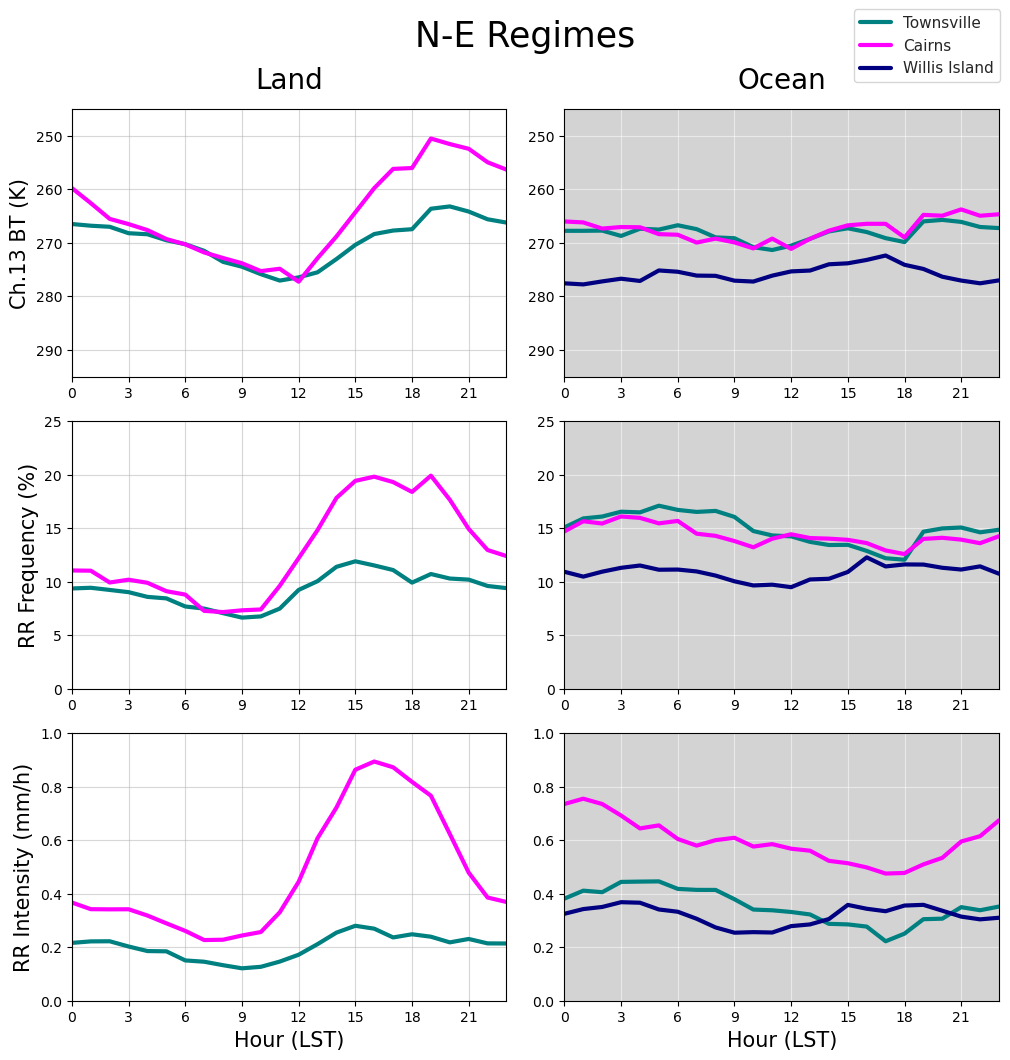

In [17]:
diurnal_cycle_plot('N-E Regimes',245,295,25,1,
                      h8_ne_towns_land,h8_ne_cairns_land,h8_ne_towns_ocean,h8_ne_cairns_ocean,h8_ne_willis_ocean,            # clouds
                      towns_rrf_ne,cairns_rrf_ne,towns_rrf_ocean_ne,cairns_rrf_ocean_ne,willis_rrf_ne,                       # frequency
                      towns_rri_land_ne,cairns_rri_land_ne,towns_rri_ocean_ne,cairns_rri_ocean_ne,willis_rri_ne)             # intensity

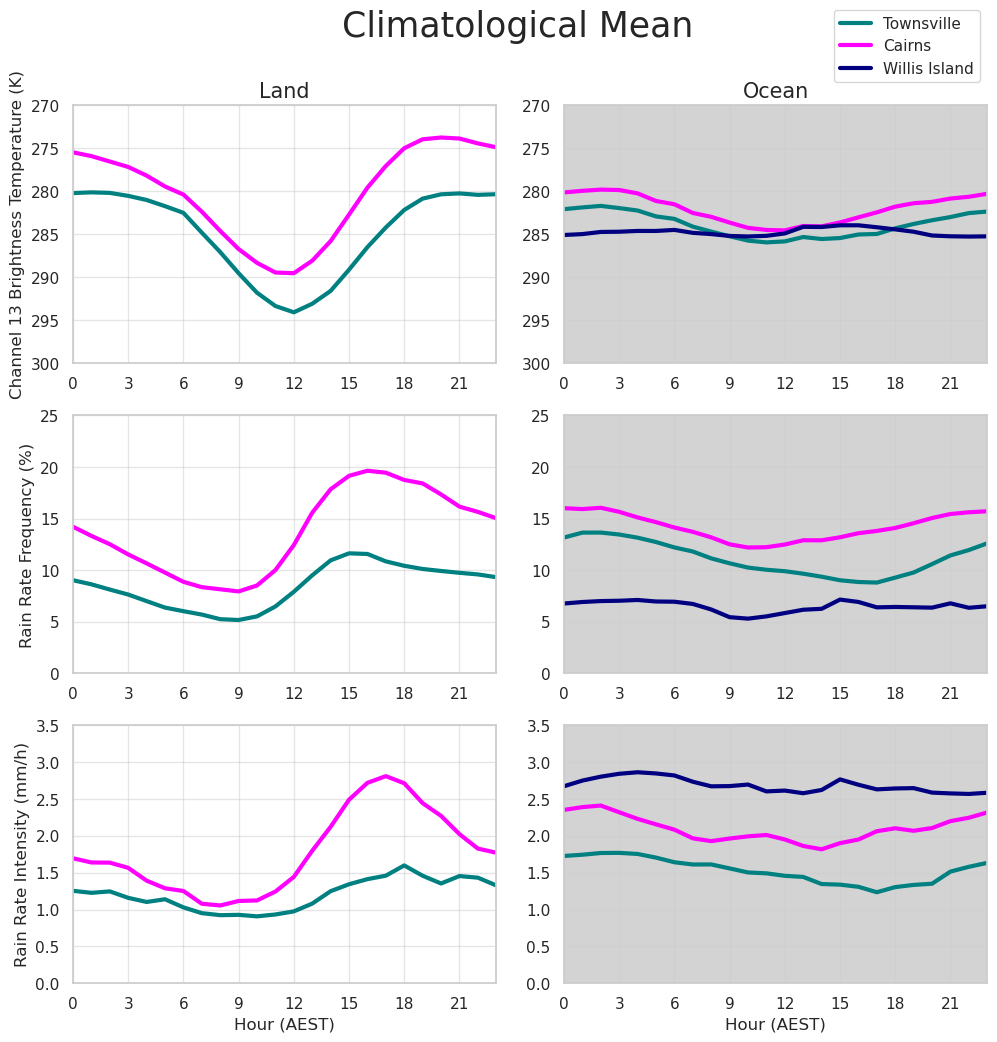

In [15]:
diurnal_cycle_plot('Climatological Mean',270,300,25,3.5,
                       bt_land_Tm,bt_land_Cm,bt_ocean_Tm,bt_ocean_Cm,bt_willism,
                      rr_land_Tf,rr_land_Cf,rr_ocean_Tf,rr_ocean_Cf,rr_willisf,
                      rr_land_T,rr_land_C,rr_ocean_T,rr_ocean_C,rr_willis)

# original plots

NameError: name 'rr_willis' is not defined

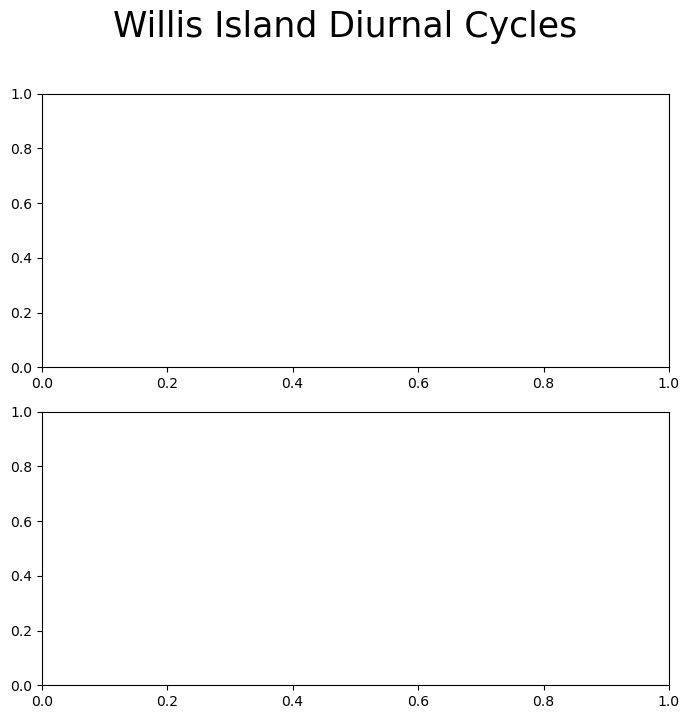

In [29]:
fig,ax = plt.subplots(2,1, figsize=[7,7])
fig.patch.set_facecolor('white')
fig.suptitle('Willis Island Diurnal Cycles',y=1.02,fontsize=25)
fig.tight_layout()

# ax[0].plot(np.arange(0,24,1),rr_land_T,linewidth=3,color="green",label='Land')
ax[0].plot(np.arange(0,24,1),rr_willis,linewidth=3,color="darkblue",linestyle='-',label='Intensity')
ax0 = ax[0].twinx()
ax0.set_ylabel('Percent raining (%)')
# ax0.plot(np.arange(0,24,1),rr_land_Tf,linewidth=3,color="green",linestyle='--',label='Land')
ax0.plot(np.arange(0,24,1),rr_willisf,linewidth=3,color="darkblue",linestyle='--',label='Frequency')

# ax[1].plot(np.arange(0,24,1),bt_land_T,linewidth=3,color="green",label='Land')
ax[1].plot(np.arange(0,24,1),bt_willis,linewidth=3,color="darkblue",linestyle='-',label='Ocean')

# ax[2].plot(np.arange(0,24,1),bt_willis,linewidth=3,color="royalblue")

# valid_indices = np.where(~np.isnan(rr_willisf))[0]
# ax0.plot(np.arange(0,24,1)[valid_indices[14:16]], np.array(rr_willisf)[valid_indices[14:16]], linestyle='--',linewidth=3,color="grey",label='Invalid data')
# ax0.plot(np.arange(0,24,1)[valid_indices[18:22]], np.array(rr_willisf)[valid_indices[18:22]], linestyle='--',linewidth=3,color="grey")
ax[0].set_xlim(0,23)
ax[1].set_xlim(0,23)
# ax[2].set_xlim(0,23)

ax[0].legend(loc='upper left')#loc='lower right',bbox_to_anchor=(1, 1))
ax0.legend(loc='upper right')
# ax[1].legend(loc='upper left')
ax[0].set_title("Rain Rate",fontsize=15,pad=5)
ax[1].set_title("Ch13 Brightness Temperature",fontsize=15,pad=4)
# ax[2].set_title("Willis Island",fontsize=18,pad=5)

ax[1].set_xlabel("Hour (AEST)",fontsize=15)
ax[0].set_ylabel("Rain rate (mm/h)",fontsize=12)
ax[1].set_ylabel("(K)",fontsize=12)
# ax[2].set_ylabel("Percent Raining (%)",fontsize=12)

ax[0].set_xticks(np.arange(0,24,2))
ax[1].set_xticks(np.arange(0,24,2))
# ax[2].set_xticks(np.arange(0,24,2))
ax[0].set_xticklabels([])
ax[1].set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"],fontsize=12)
# ax[2].set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"],fontsize=12)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
# ax[2].grid(alpha=0.5)

ax[0].set_ylim(0,4)
ax0.set_ylim(0,25)
ax[1].set_ylim(280,300)
# ax[2].set_ylim(270,300)

# Original arrays from ungridded files

In [41]:
rr_land_T = np.array([1.254824 , 1.2276372, 1.2471322, 1.1595162, 1.1036109, 1.1402779, 1.0300751, 0.9514166, 0.9241691, 0.9286411, 0.9083281, 0.9334987,
             0.9757378, 1.0813134, 1.2498484, 1.3440546, 1.4133714, 1.4603032, 1.5997088, 1.4593925, 1.3546082, 1.4551674, 1.433393 , 1.3281772])
rr_ocean_T = np.array([1.7281376, 1.7448484, 1.7682054, 1.7700436, 1.7552778, 1.7053998, 1.6426173, 1.6122385, 1.613013 , 1.5589262, 1.5041673, 1.4921347,
              1.4585742, 1.4434127, 1.3469119, 1.3385173, 1.309448 , 1.2357172, 1.3053614, 1.3349596, 1.3512006, 1.5159793, 1.5807471, 1.6345497])
rr_land_C = np.array([1.6965562, 1.6399091, 1.6372764, 1.5667461, 1.3927646, 1.2892879, 1.2524694, 1.0795707, 1.0560687, 1.116984 , 1.1244656, 1.2451352,
                      1.444024 , 1.7989283, 2.1236923, 2.492031 , 2.720846 , 2.8117666, 2.715315 , 2.4452953, 2.2726147, 2.0247626, 1.8282522, 1.7723124])
rr_ocean_C = np.array([2.353462 , 2.391276 , 2.4124808, 2.3214912, 2.2316918, 2.1573987, 2.0852263, 1.967367 , 1.9296213, 1.9646109, 1.9945257, 2.0125716, 
                       1.952079 , 1.8638947, 1.8189062, 1.9019389, 1.9513342, 2.0640821, 2.103818 , 2.0700092, 2.1069145, 2.2012556, 2.2468367, 2.3191667])
rr_willis = np.array([2.674555 , 2.751607 , 2.8046105, 2.8437536, 2.864564 , 2.848287 , 2.8208466, 2.735871 , 2.6735976, 2.6765227, 2.6975617, 2.6046987, 
             2.6158593, 2.5797856, 2.62402 , 2.7676237, 2.694977 , 2.6320322, 2.6446216, 2.6489267, 2.5883126, 2.5772882, 2.5700297, 2.586267])

In [23]:
# frequency
rr_land_Tf = np.array([9.020651 , 8.62395198, 8.1161216 , 7.63228745, 6.99384805, 6.36819015, 6.01765106, 5.69094488, 5.24293622, 5.16189289, 5.51543635, 
                      6.47874111, 7.89943581, 9.49631909, 10.9470889 , 11.62874661, 11.56690137, 10.84827215, 10.41998384, 10.11245176, 9.91737698, 9.74045392, 
                      9.5834865 , 9.31680227])
rr_ocean_Tf = np.array([13.16279295, 13.63786214, 13.64316276, 13.45421383, 13.14591476, 12.72374338, 12.20112091, 11.80598585, 11.14154508, 10.66077231, 10.24747366, 
                       10.03583466, 9.89606601, 9.65354438, 9.36240602, 9.01833955, 8.8478996 , 8.79401634, 9.27313788, 9.771797 , 10.5831196 , 11.42692002, 
                        11.94752541,12.60149524])
rr_land_Cf = np.array([14.20647577, 13.32096018, 12.51350642, 11.52195257, 10.65524158, 9.76116534, 8.86628738, 8.34901383, 8.14212313, 7.93584253, 8.51156388, 
                       10.00667177,12.42952202, 15.57008312, 17.84449322, 19.14337227, 19.63479205, 19.44838152, 18.74255988, 18.40924876, 17.34193472, 16.15706102,
                       15.64941084,15.03067201])
rr_ocean_Cf = np.array([16.00674359, 15.92130268, 16.04713793, 15.65411352, 15.11034434, 14.65301606, 14.1331226 , 13.71426339, 13.17922508, 12.50341756, 12.19257282,
                       12.22524088, 12.48212403, 12.89592615, 12.89273561, 13.18618408, 13.58108827, 13.80090503, 14.08930993, 14.54931662, 15.05180091, 15.4422917 , 
                       15.61034666, 15.70998992])
rr_willisf = np.array([5.2951301478812605,5.515378807661537,5.837915231884183,6.159669404011951,6.248870698618676,7.1440116918,6.9133462314,6.391163025986274,
                       6.4283535659622455,6.3969696755134935,6.36196513089028,6.7793209194,6.3490369923,6.497633401223204,6.762287056952941,6.909237034835771,
                       6.999274992929699,7.031259705278786,7.105149139435779,6.9590351183986945,6.936265717313653,6.720185182178033,6.183628259332497,
                       5.438199780853524])
rr_willisf = np.roll(rr_willisf,shift=10)

In [24]:
# bt median
bt_land_T = np.array([296.47653,297.76483,298.50388,298.45282,297.02362,295.34277,293.39206,292.31168,290.52014,289.21014,288.8845,289.1518,289.34973,
                     288.59766,287.9886,287.84647,287.7413,288.29926,287.94168,288.00262,288.63058,290.45972,292.36108,294.49387])
bt_ocean_T = np.array([292.68973,292.98962,293.1793,293.25446,293.33813,293.4368,292.98502,292.909,292.42416,292.55453,292.28397,292.30182,291.81934,
                      291.3183,290.75336,290.6715,290.56018,290.53067,290.8423,290.95416,291.2702,291.761,292.03412,292.46802])
bt_land_C = np.array([292.52448,293.58472,293.5065,292.36328,290.32092,288.26477,286.06512,284.36917,282.6345,281.83536,281.79544,281.49493,282.74283,
                     283.24878,282.86438,283.21686,283.35074,282.94818,283.99426,285.08682,285.94373,287.7059,289.50302,291.38843])
bt_ocean_C = np.array([291.68613,291.90366,291.87097,291.6441,291.54895,291.4468,290.46948,289.8254,289.4882,289.5644,288.9923,288.51733,288.37326,
                      288.43048,287.90237,287.34158,286.98746,287.30188,287.94583,288.5997,289.26276,290.2388,290.6006,290.91785])
bt_willis = np.array([291.7127,291.82272,291.9283,291.75433,291.7188,291.70383,291.6744,291.8794,291.79398,291.68118,291.50742,291.15704,291.22748,
                     291.08752,291.05762,290.94,290.57922,290.9607,290.74518,290.891,291.09912,291.33484,291.77707,291.8171])
bt_land_T = np.roll(bt_land_T,shift=10)
bt_ocean_T = np.roll(bt_ocean_T,shift=10)
bt_land_C = np.roll(bt_land_C,shift=10)
bt_ocean_C = np.roll(bt_ocean_C,shift=10)
bt_willis = np.roll(bt_willis,shift=10)

In [25]:
# bt mean
bt_land_Tm = np.array([291.7938,293.34094,294.07153,293.07672,291.58142,289.11362,286.49063,284.19876,282.1625,280.84363,280.34073,280.23608,280.40424,
                     280.33066,280.19852,280.1119,280.1747,280.52417,281.0007,281.72064,282.4981,284.80197,287.0607,289.52103])
bt_ocean_Tm = np.array([285.7287,285.936,285.81934,285.3125,285.5432,285.429,285.01865,284.95505,284.29984,283.79117,283.3585,282.98685,282.52637,
                      282.34637,282.06982,281.86362,281.69058,281.94452,282.22876,282.91293,283.20132,284.1026,284.67953,285.22498])
bt_land_Cm = np.array([288.31918,289.44284,289.52155,288.06735,285.7833,282.7023,279.56384,277.04083,274.97607,273.93912,273.73196,273.8488,274.41467,
                     274.86807,275.45407,275.89606,276.52585,277.1573,278.16293,279.4305,280.3707,282.36563,284.6025,286.71246])
bt_ocean_Cm = np.array([284.2448,284.48758,284.53955,284.02988,284.06906,283.61652,283.02048,282.43976,281.77722,281.3784,281.21863,280.83258,280.6281,
                      280.27896,280.12253,279.93484,279.79584,279.84293,280.23166,281.11542,281.4993,282.5131,282.96106,283.62918])
bt_willism = np.array([285.24756,285.1723,284.89185,284.12744,284.14563,283.9473,283.94708,284.17557,284.4247,284.6948,285.13486,285.22696,285.2575,
                     285.23218,285.074,284.97052,284.72064,284.69498,284.60275,284.60547,284.4852,284.824,284.9699,285.18594])
bt_land_Tm = np.roll(bt_land_Tm,shift=10)
bt_ocean_Tm = np.roll(bt_ocean_Tm,shift=10)
bt_land_Cm = np.roll(bt_land_Cm,shift=10)
bt_ocean_Cm = np.roll(bt_ocean_Cm,shift=10)
bt_willism = np.roll(bt_willism,shift=10)